# InceptionTime Results

This notebook makes up the data for the deep learning result section of the paper.

In [1]:
import pandas as pd
from tsai.all import *
from sklearn.metrics import roc_auc_score, classification_report

## Loading and preparing the data

In [2]:
df = pd.read_hdf("merged_20210405.h5")
print(f"Number of frames: {len(df)}")
df = df[(df['behavior'] != "not_defined")]
print(f"Number of frames after dropping non-labelled frames: {len(df)}")

df.loc[(df['behavior'] == "back_preening") | (df['behavior'] == "front_preening"), 'behavior'] = "preening"
df.loc[(df['behavior'] == "standing_shaking") | (df['behavior'] == "scratch_with_feet"), 'behavior'] = "standing"
df.loc[(df['behavior'] == "body_pump") | (df['behavior'] == "feather_clapping"), 'behavior'] = "fluffing"

Number of frames: 10424241
Number of frames after dropping non-labelled frames: 865548


We use the same features as for RandomForest.
For windows, label of the window is defined by the modal (most common) value of the window.

In [3]:
features = [('head', 'x'), ('head', 'y'), 
            ('tail', 'x'), ('tail', 'y'),  
            
            ('left_neck', 'x'), ('left_neck', 'y'), 
            ('right_neck', 'x'), ('right_neck', 'y'), 
            
            ('left_up_wing', 'x'), ('left_up_wing', 'y'),
            ('left_middle_wing', 'x'), ('left_middle_wing', 'y'),
            ('left_down_wing', 'x'), ('left_down_wing', 'y'),
            
            ('right_up_wing', 'x'), ('right_up_wing', 'y'),
            ('right_middle_wing', 'x'), ('right_middle_wing', 'y'),
            ('right_down_wing', 'x'), ('right_down_wing', 'y'),
]
def y_func(o): 
    return scipy.stats.mode(o, axis=1).mode.ravel()

## 16 Frames

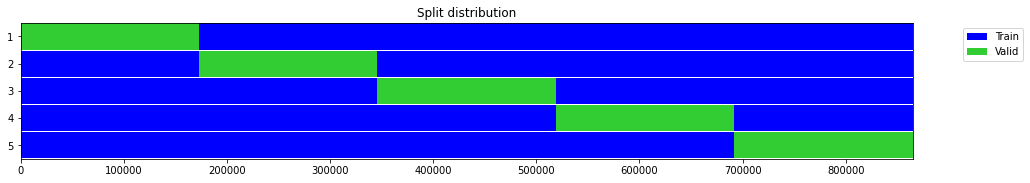

In [5]:
x, y = SlidingWindow(16, get_x=features, get_y='behavior', y_func=y_func)(df)
splits = get_splits(y, n_splits=5, shuffle=False, stratify=True, check_splits=True)
tfms  = [None, [Categorize()]]

First some manual experiments to find some hyper parameters for the model. For this, we want to use the last split.

In [55]:
bs = 1024

last_split = splits[-1]

tfms  = [None, [Categorize()]] 
dsets = TSDatasets(x, y, tfms=tfms, splits=last_split, inplace=True)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, batch_tfms=[TSStandardize()], num_workers=0)



Minimum/10: 0.10964782238006592, steepest point: 0.001737800776027143


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.343953,0.513091,0.855672,0.830308,00:12
1,0.238416,0.379724,0.891205,0.879879,00:12
2,0.206470,0.380006,0.896520,0.889418,00:12
3,0.185836,0.393178,0.896815,0.891814,00:12
4,0.174170,0.396790,0.898438,0.889616,00:12
5,0.160151,0.385449,0.900922,0.893046,00:12
6,0.153962,0.381299,0.904140,0.898090,00:12
7,0.154680,0.381764,0.904296,0.897917,00:12


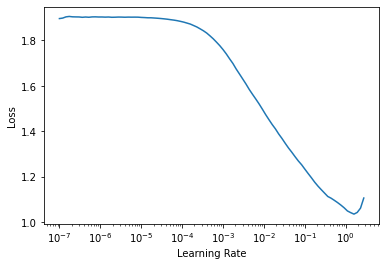

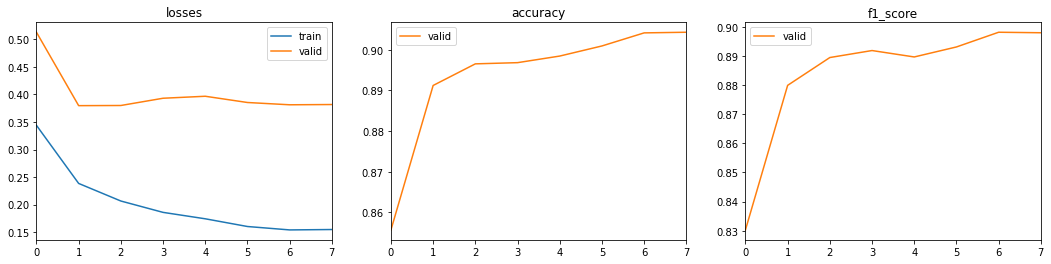

In [68]:
model = InceptionTime(dls.vars, dls.c, depth=1, ks=20)
f1 = F1Score(average="weighted")
learn = Learner(dls, model, metrics=[accuracy, f1])
lrm_in,lr_steep = learn.lr_find(suggestions=True)
print(f"Minimum/10: {lr_min}, steepest point: {lr_steep}")

learn.fit_one_cycle(8, lr_max=lr_steep)
learn.recorder.plot_metrics()

## Cross validation

We do cross val using some specific hyperparameters.

In [3]:
import time
import numpy as np

def save_split(x, y, i, splits, bs):
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(x, y, tfms=tfms, splits=splits, inplace=True)
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, batch_tfms=[TSStandardize()], num_workers=0)
    
    torch.save(dls, f"dls_{bs}_{i}.pkl")
    
def train_and_evaluate_it(i, bs, lr, epochs, depth):

    start = time.time()
    dls = torch.load(f"dls_{bs}_{i}.pkl")
    end = time.time()
    print(end - start)
    
    model = InceptionTime(dls.vars, dls.c, depth=depth, ks=20)
    f1 = F1Score(average="weighted")
    learn = Learner(dls, model, metrics=[accuracy, f1])
    learn.recorder.train_metrics = True

    learn.fit_one_cycle(epochs, lr_max=lr)
    
    return learn

def cross_val_score(bs, lr, epochs, depth):
    scores = []
    for i in range(5):
        print(f'===================== Fold {i} ============================')
        model = train_and_evaluate_it(i, bs,  lr, epochs, depth)
        scores.append(model.final_record)
    
    return scores

scores = []

for d in range(1, 7):
    print(f'+++++++++++++++++++ Depth {d} +++++++++++++++++++')
    s = cross_val_score(1024, 0.005, 8, d)
    scores.append(s)

+++++++++++++++++++ Depth 1 +++++++++++++++++++
===================== Fold 0 ============================
26.417078971862793


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.304707,0.855269,0.835311,0.970873,0.797333,0.826628,00:17
1,0.228698,0.915977,0.908389,0.816981,0.908294,0.901336,00:13
2,0.190765,0.930563,0.926656,0.957146,0.902101,0.897723,00:13
3,0.171693,0.939703,0.937146,1.115454,0.901558,0.906648,00:13
4,0.154068,0.946135,0.944321,1.058907,0.908762,0.904050,00:13
5,0.139089,0.951874,0.950471,1.247502,0.902505,0.904990,00:13
6,0.132281,0.955668,0.954503,1.213510,0.907918,0.908789,00:13
7,0.128372,0.957836,0.956775,1.238643,0.902032,0.904775,00:13


===================== Fold 1 ============================
23.642162799835205


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.283084,0.853833,0.838804,0.481538,0.859925,0.856825,00:13
1,0.213368,0.923253,0.916778,0.620706,0.819747,0.826060,00:13
2,0.179470,0.937711,0.934529,0.594332,0.844628,0.855546,00:13
3,0.158750,0.945425,0.943423,0.600756,0.846898,0.843879,00:13
4,0.141595,0.951225,0.949725,0.773594,0.789957,0.788976,00:13
5,0.128385,0.955969,0.954826,0.504078,0.876146,0.876973,00:13
6,0.123099,0.959387,0.958410,0.512313,0.874887,0.877933,00:13
7,0.120580,0.961748,0.960869,0.530299,0.870808,0.875474,00:13


===================== Fold 2 ============================
24.157520294189453


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.269817,0.867017,0.847430,0.547637,0.848561,0.837419,00:13
1,0.212250,0.924569,0.918511,1.018464,0.631549,0.645044,00:13
2,0.176986,0.937288,0.933993,0.892350,0.710143,0.731219,00:13
3,0.156828,0.944814,0.942534,1.054756,0.687145,0.716092,00:13
4,0.142826,0.950673,0.948976,0.824649,0.807586,0.821756,00:13
5,0.128765,0.955087,0.953651,0.894345,0.790672,0.812234,00:13
6,0.124044,0.958652,0.957489,0.825483,0.819197,0.828971,00:13
7,0.118640,0.960537,0.959421,0.863338,0.802058,0.815905,00:13


===================== Fold 3 ============================
24.993677139282227


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.278154,0.859290,0.844378,0.427217,0.868381,0.837761,00:13
1,0.213608,0.924701,0.917325,0.627272,0.792098,0.808373,00:13
2,0.183426,0.937150,0.933068,0.432274,0.879837,0.862705,00:13
3,0.162837,0.945016,0.942354,0.463584,0.859323,0.846875,00:13
4,0.145305,0.950636,0.948673,0.422141,0.882916,0.868249,00:13
5,0.129112,0.955382,0.953791,0.415096,0.884499,0.879560,00:13
6,0.126520,0.959020,0.957662,0.413704,0.885873,0.877624,00:12
7,0.122050,0.960823,0.959569,0.418762,0.885764,0.879810,00:13


===================== Fold 4 ============================
24.97601008415222


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.286587,0.854421,0.838435,0.495017,0.859086,0.864721,00:13
1,0.214260,0.921444,0.914178,0.406580,0.892003,0.878870,00:13
2,0.187365,0.934037,0.929934,0.396506,0.894775,0.885014,00:13
3,0.169575,0.942588,0.939912,0.627720,0.817649,0.813536,00:13
4,0.149125,0.948218,0.946197,0.502347,0.877474,0.879377,00:13
5,0.135030,0.953212,0.951581,0.447493,0.895654,0.892776,00:13
6,0.127986,0.956843,0.955453,0.434929,0.902788,0.900850,00:13
7,0.125973,0.958797,0.957476,0.441799,0.899923,0.895368,00:13


+++++++++++++++++++ Depth 2 +++++++++++++++++++
===================== Fold 0 ============================
28.280982494354248


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.214673,0.888711,0.876781,0.777584,0.905145,0.897422,00:18
1,0.150375,0.940934,0.938704,0.773704,0.901708,0.898060,00:17
2,0.106318,0.958817,0.958148,0.846438,0.909004,0.906124,00:17
3,0.081446,0.969818,0.969520,1.063450,0.775081,0.824233,00:17
4,0.056991,0.978120,0.977992,0.985192,0.907127,0.908458,00:17
5,0.044002,0.984496,0.984432,1.175053,0.899848,0.901508,00:17
6,0.033924,0.989067,0.989027,1.185078,0.911009,0.912295,00:41
7,0.029505,0.991282,0.991253,1.237082,0.907034,0.910447,00:17


===================== Fold 1 ============================
22.575355052947998


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.204375,0.897465,0.887791,0.611048,0.807587,0.822730,00:17
1,0.139142,0.946308,0.944709,0.808725,0.752893,0.753671,00:17
2,0.101598,0.961632,0.961097,0.657228,0.830244,0.843255,00:17
3,0.078765,0.970744,0.970469,1.115589,0.697621,0.729413,00:17
4,0.059270,0.978269,0.978131,0.630296,0.875961,0.880320,00:17
5,0.042646,0.984265,0.984190,0.758196,0.866851,0.874088,00:17
6,0.034372,0.988800,0.988755,0.820711,0.846136,0.861419,00:17
7,0.029620,0.991055,0.991023,0.831886,0.854431,0.866172,00:17


===================== Fold 2 ============================
23.50901961326599


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.196895,0.901512,0.892003,0.785820,0.718652,0.730803,00:17
1,0.141316,0.944889,0.942918,1.032583,0.638118,0.655439,00:17
2,0.101186,0.961241,0.960547,1.560324,0.622243,0.626787,00:17
3,0.081655,0.970729,0.970403,1.377758,0.643403,0.654510,00:17
4,0.059623,0.977861,0.977684,1.470071,0.650740,0.674543,00:17
5,0.044974,0.983695,0.983587,1.466740,0.667764,0.684064,00:17
6,0.035934,0.988147,0.988085,1.017717,0.788228,0.802299,00:17
7,0.031840,0.990399,0.990351,1.109084,0.746132,0.762557,00:17


===================== Fold 3 ============================
25.103209972381592


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.191492,0.896721,0.887387,0.406853,0.868173,0.857056,00:17
1,0.137092,0.946033,0.943962,0.679923,0.774889,0.798551,00:17
2,0.106264,0.960943,0.960156,0.463631,0.868543,0.862231,00:17
3,0.080091,0.971102,0.970717,0.474448,0.872512,0.871942,00:17
4,0.059827,0.978412,0.978224,0.531057,0.860895,0.870311,00:17
5,0.044297,0.984041,0.983937,0.551143,0.870345,0.874041,00:17
6,0.036473,0.988368,0.988304,0.555849,0.875175,0.876978,00:17
7,0.032136,0.990385,0.990341,0.557665,0.878352,0.879607,00:17


===================== Fold 4 ============================
26.213767290115356


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.207296,0.892464,0.882136,0.438009,0.887404,0.876687,00:17
1,0.141469,0.943030,0.940947,0.486835,0.871922,0.866551,00:17
2,0.103194,0.959697,0.959049,0.441095,0.904088,0.893614,00:17
3,0.083783,0.969813,0.969517,0.565275,0.857827,0.860667,00:17
4,0.059262,0.977907,0.977766,0.510437,0.897687,0.898462,00:17
5,0.043112,0.984173,0.984099,0.598552,0.901968,0.900968,00:17
6,0.034694,0.988492,0.988450,0.616500,0.904544,0.902290,00:17
7,0.031696,0.990931,0.990901,0.627563,0.902447,0.901433,00:17


+++++++++++++++++++ Depth 3 +++++++++++++++++++
===================== Fold 0 ============================
33.53912353515625


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.177486,0.893186,0.889025,0.566857,0.910408,0.903800,00:22
1,0.122506,0.950572,0.949616,0.873713,0.800332,0.836103,00:22
2,0.078584,0.967571,0.967260,0.786778,0.899681,0.903434,00:22
3,0.058628,0.978348,0.978232,1.320253,0.698395,0.753933,00:22
4,0.035276,0.986123,0.986069,1.204454,0.890946,0.895013,00:22
5,0.022114,0.991537,0.991516,1.208405,0.835899,0.861665,00:22
6,0.013750,0.995181,0.995171,1.172634,0.867388,0.882538,00:22
7,0.010792,0.996794,0.996789,1.196855,0.871317,0.885488,00:23


===================== Fold 1 ============================
27.151046991348267


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.167538,0.912479,0.907026,0.710893,0.775884,0.797440,00:22
1,0.116204,0.954000,0.953099,1.006016,0.664335,0.667026,00:22
2,0.080976,0.968366,0.968039,0.717130,0.836691,0.848276,00:23
3,0.058048,0.978120,0.977974,0.768417,0.824669,0.843657,00:22
4,0.036711,0.985119,0.985051,0.866157,0.815415,0.836474,00:22
5,0.024297,0.990662,0.990635,1.363126,0.752852,0.802735,00:22
6,0.015377,0.994334,0.994322,1.073077,0.797501,0.830320,00:22
7,0.011851,0.996322,0.996315,1.130703,0.796646,0.830331,00:22


===================== Fold 2 ============================
27.0572566986084


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.160794,0.908033,0.902181,0.829594,0.737086,0.764221,00:23
1,0.118421,0.953918,0.952998,1.312741,0.638175,0.639724,00:22
2,0.079244,0.969165,0.968852,1.477020,0.594480,0.614791,00:22
3,0.055970,0.978649,0.978508,1.073803,0.707711,0.722880,00:22
4,0.035433,0.985466,0.985395,1.218394,0.682108,0.700931,00:22
5,0.024372,0.990944,0.990910,0.888653,0.830740,0.838265,00:22
6,0.015499,0.994661,0.994648,1.018739,0.817649,0.828275,00:22
7,0.012211,0.996269,0.996260,1.071853,0.798378,0.810844,00:22


===================== Fold 3 ============================
27.393736124038696


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.162428,0.906171,0.901327,0.442169,0.872731,0.855501,00:23
1,0.112389,0.955403,0.954373,0.613564,0.800267,0.819587,00:22
2,0.080717,0.969490,0.969158,0.639237,0.848948,0.849545,00:22
3,0.055678,0.978962,0.978821,0.540066,0.864170,0.869814,00:22
4,0.036127,0.985970,0.985913,0.605884,0.865568,0.868249,00:22
5,0.023352,0.991150,0.991125,0.611118,0.883909,0.881180,00:21
6,0.015538,0.994740,0.994729,0.647497,0.881339,0.881957,00:22
7,0.012304,0.996400,0.996395,0.650985,0.884961,0.884599,00:23


===================== Fold 4 ============================
27.727115631103516


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.171464,0.907305,0.899832,0.392468,0.885169,0.887435,00:22
1,0.119841,0.952570,0.951552,0.589141,0.827181,0.841763,00:22
2,0.083298,0.967418,0.967082,0.644397,0.821566,0.840475,09:02
3,0.058910,0.977792,0.977649,0.513843,0.882263,0.883613,00:22
4,0.038246,0.985259,0.985199,0.491047,0.902314,0.902133,00:22
5,0.023670,0.990915,0.990891,0.575316,0.899599,0.898063,00:22
6,0.015325,0.994593,0.994583,0.604317,0.898288,0.897543,00:22
7,0.012604,0.996387,0.996382,0.613745,0.898039,0.898334,00:22


+++++++++++++++++++ Depth 4 +++++++++++++++++++
===================== Fold 0 ============================
22.92965030670166


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.163615,0.911321,0.905870,0.572872,0.893436,0.902110,00:26
1,0.111816,0.955055,0.954567,0.988681,0.758202,0.762875,00:26
2,0.070283,0.971178,0.971060,0.754071,0.893973,0.898661,00:26
3,0.050263,0.980899,0.980845,0.993015,0.844894,0.875411,00:26
4,0.030122,0.988158,0.988137,1.031426,0.898577,0.904085,00:26
5,0.017995,0.992978,0.992966,1.110208,0.880536,0.891637,00:26
6,0.010485,0.996124,0.996120,1.199185,0.896509,0.903200,00:26
7,0.007555,0.997681,0.997680,1.216542,0.902234,0.907043,00:26


===================== Fold 1 ============================
24.46892261505127


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.158963,0.916693,0.911278,0.489541,0.862703,0.865777,00:26
1,0.109686,0.957158,0.956507,0.556250,0.842179,0.855568,00:27
2,0.070874,0.971099,0.970889,0.561524,0.868446,0.875391,00:26
3,0.050107,0.980924,0.980848,0.713018,0.861964,0.867433,00:26
4,0.030785,0.987766,0.987728,0.863494,0.845575,0.857600,00:26
5,0.018920,0.992638,0.992626,0.847500,0.864708,0.873912,00:26
6,0.011072,0.995874,0.995868,0.973297,0.851468,0.866302,00:27
7,0.007677,0.997466,0.997463,0.977726,0.860497,0.871074,00:26


===================== Fold 2 ============================
27.280725479125977


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.157119,0.916748,0.912090,0.620016,0.828284,0.827903,00:27
1,0.109433,0.956166,0.955420,0.820398,0.746196,0.782399,00:27
2,0.071549,0.970674,0.970380,0.991589,0.714400,0.742797,00:27
3,0.050101,0.980593,0.980460,0.867005,0.763082,0.786876,00:27
4,0.032324,0.987254,0.987197,1.461425,0.649071,0.668965,00:27
5,0.019653,0.992255,0.992231,1.692133,0.652693,0.658011,00:27
6,0.011855,0.995526,0.995517,1.388440,0.694569,0.707148,00:27
7,0.008595,0.997234,0.997230,1.480987,0.682270,0.693561,00:25


===================== Fold 3 ============================
27.20937418937683


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.150489,0.920812,0.914215,0.416914,0.866302,0.867040,00:27
1,0.104002,0.958537,0.957784,0.929880,0.723366,0.773357,00:26
2,0.071576,0.971989,0.971753,0.555682,0.869600,0.862422,00:27
3,0.047221,0.981437,0.981333,0.569127,0.870559,0.872163,00:26
4,0.030974,0.987737,0.987692,0.675692,0.864921,0.871762,00:27
5,0.017858,0.992534,0.992517,0.694472,0.885238,0.884110,00:26
6,0.011804,0.995860,0.995854,0.756409,0.880212,0.881186,00:26
7,0.008218,0.997368,0.997365,0.768104,0.886208,0.883872,00:27


===================== Fold 4 ============================
32.73758006095886


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.158234,0.916989,0.911982,0.549256,0.824501,0.839765,00:25
1,0.105660,0.957064,0.956412,0.357030,0.910974,0.909736,00:26
2,0.067668,0.971983,0.971787,0.539498,0.878739,0.880986,00:26
3,0.048417,0.981201,0.981122,0.525039,0.899819,0.896738,00:26
4,0.031687,0.987982,0.987951,0.580271,0.892742,0.895093,00:26
5,0.018065,0.992736,0.992724,0.664367,0.897935,0.896522,00:26
6,0.010603,0.995851,0.995847,0.695569,0.893961,0.895470,00:26
7,0.007968,0.997434,0.997433,0.716593,0.895711,0.897394,00:26


+++++++++++++++++++ Depth 5 +++++++++++++++++++
===================== Fold 0 ============================
29.87711787223816


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.154954,0.916442,0.910999,0.534977,0.890160,0.890196,00:30
1,0.104016,0.956713,0.956307,0.471935,0.907364,0.911074,00:30
2,0.064986,0.972216,0.972100,0.582583,0.908097,0.906844,00:30
3,0.047097,0.982392,0.982349,1.095216,0.754429,0.799744,00:30
4,0.027076,0.989064,0.989046,0.666932,0.900992,0.902184,00:30
5,0.016073,0.993875,0.993868,0.875699,0.868798,0.881122,00:30
6,0.009115,0.996670,0.996667,0.801095,0.899588,0.903535,00:30
7,0.005812,0.998015,0.998014,0.809639,0.896486,0.901951,00:30


===================== Fold 1 ============================
27.772966384887695


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.147366,0.924377,0.920081,0.528673,0.853177,0.846624,00:30
1,0.104466,0.958716,0.958168,0.886726,0.677777,0.675118,00:30
2,0.067702,0.973202,0.973031,0.690601,0.811146,0.822786,00:30
3,0.047373,0.982029,0.981959,0.731519,0.849405,0.862379,00:30
4,0.028741,0.988553,0.988524,0.804074,0.847649,0.864033,00:30
5,0.017826,0.993161,0.993150,0.891361,0.850064,0.864022,00:30
6,0.009264,0.996217,0.996212,0.973169,0.850838,0.865778,00:30
7,0.006791,0.997735,0.997733,1.014119,0.849995,0.864406,00:29


===================== Fold 2 ============================
55.39413523674011


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.145955,0.923389,0.919095,1.214411,0.647482,0.661226,00:31
1,0.104704,0.958921,0.958322,1.007696,0.699103,0.719203,00:30
2,0.065714,0.973250,0.973022,0.697688,0.836124,0.849446,00:30
3,0.045580,0.982221,0.982125,1.149999,0.688538,0.700980,00:30
4,0.029124,0.988416,0.988373,1.783395,0.640070,0.651566,00:30
5,0.018199,0.992946,0.992927,1.456964,0.694777,0.708240,00:30
6,0.011004,0.996121,0.996114,1.596873,0.702275,0.716676,00:30
7,0.007198,0.997689,0.997686,1.724535,0.697729,0.712027,00:30


===================== Fold 3 ============================
28.047295331954956


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.147241,0.923535,0.918810,0.474812,0.864545,0.846376,00:30
1,0.100862,0.959421,0.958774,0.876665,0.739495,0.778145,00:30
2,0.066539,0.974014,0.973830,0.510421,0.871143,0.864011,00:30
3,0.045474,0.982906,0.982837,0.547611,0.880975,0.880005,00:30
4,0.027312,0.988989,0.988966,0.660348,0.875851,0.877766,14:53
5,0.016299,0.993518,0.993510,0.829849,0.852154,0.861038,00:30
6,0.009743,0.996422,0.996419,0.805200,0.879103,0.882323,00:30
7,0.007199,0.997772,0.997771,0.800797,0.881079,0.883272,00:30


===================== Fold 4 ============================
23.06434988975525


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.154954,0.917641,0.913815,0.495630,0.849092,0.862528,00:30
1,0.105285,0.957397,0.956771,0.411898,0.899362,0.892287,00:30
2,0.065906,0.972162,0.971978,0.525049,0.867295,0.870906,00:30
3,0.046307,0.982092,0.982024,0.572858,0.886653,0.886224,00:30
4,0.029325,0.988564,0.988537,0.611474,0.886584,0.890055,00:30
5,0.016572,0.993223,0.993213,0.640712,0.900795,0.900907,00:30
6,0.009730,0.996310,0.996307,0.722807,0.890281,0.892668,00:30
7,0.006649,0.997796,0.997794,0.732122,0.890322,0.892386,00:30


+++++++++++++++++++ Depth 6 +++++++++++++++++++
===================== Fold 0 ============================
24.46183490753174


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.154617,0.919236,0.914460,0.616339,0.893049,0.895230,00:35
1,0.108613,0.956456,0.955974,0.756392,0.848776,0.850161,00:35
2,0.067145,0.971804,0.971649,0.853231,0.898750,0.902572,00:35
3,0.045200,0.982470,0.982407,1.089351,0.800158,0.840204,00:35
4,0.026405,0.989239,0.989215,1.039581,0.892800,0.898011,00:35
5,0.015762,0.993859,0.993849,1.140615,0.876209,0.887038,00:35
6,0.009050,0.996643,0.996639,1.116417,0.899034,0.904698,00:35
7,0.005717,0.998096,0.998095,1.184075,0.892951,0.899577,00:35


===================== Fold 1 ============================
27.173120498657227


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.146501,0.924838,0.920939,0.793019,0.759496,0.791047,00:35
1,0.103321,0.958420,0.957876,1.330719,0.668702,0.701115,00:35
2,0.066469,0.972697,0.972527,0.647591,0.851421,0.856458,00:35
3,0.047321,0.982147,0.982069,0.806428,0.831388,0.852018,00:35
4,0.027866,0.988777,0.988744,0.928955,0.820672,0.846973,00:35
5,0.016416,0.993453,0.993440,0.940391,0.834432,0.855942,00:34
6,0.008744,0.996446,0.996441,1.135912,0.812694,0.842797,00:35
7,0.006194,0.997875,0.997873,1.142398,0.818528,0.845503,00:35


===================== Fold 2 ============================
29.501326322555542


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.144978,0.925859,0.922130,0.598729,0.823750,0.833727,00:36
1,0.108022,0.959019,0.958425,1.089865,0.675239,0.692337,00:35
2,0.064073,0.973126,0.972921,1.447939,0.628234,0.652471,00:35
3,0.044948,0.982392,0.982310,0.860511,0.773873,0.789819,00:35
4,0.027881,0.988709,0.988674,1.077474,0.801237,0.822536,00:35
5,0.017181,0.993297,0.993282,1.128763,0.790828,0.807297,00:35
6,0.009232,0.996417,0.996412,1.186561,0.806523,0.825578,00:35
7,0.006931,0.997892,0.997890,1.302093,0.778055,0.797268,00:35


===================== Fold 3 ============================
34.84472417831421


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.142625,0.924965,0.920656,0.583615,0.810758,0.831834,00:36
1,0.101199,0.960071,0.959389,0.419263,0.875764,0.879900,00:35
2,0.070925,0.973457,0.973246,0.456317,0.888086,0.881300,00:35
3,0.042737,0.983154,0.983085,0.543390,0.876428,0.877218,00:35
4,0.028202,0.989207,0.989180,0.590008,0.886769,0.885594,00:35
5,0.016059,0.993596,0.993586,0.604570,0.891673,0.887665,00:35
6,0.009461,0.996633,0.996629,0.706040,0.886902,0.888589,00:35
7,0.006570,0.997874,0.997872,0.704415,0.892586,0.891990,00:35


===================== Fold 4 ============================
42.716442823410034


epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.151449,0.920256,0.916128,0.414251,0.886855,0.881678,00:35
1,0.104076,0.958173,0.957531,0.421873,0.895428,0.891572,00:35
2,0.064179,0.972903,0.972720,0.530073,0.866296,0.867031,00:35
3,0.046132,0.982374,0.982306,0.556717,0.881997,0.887017,00:35
4,0.029807,0.988985,0.988959,0.517637,0.900830,0.900778,00:35
5,0.016173,0.993590,0.993581,0.608442,0.897046,0.898402,00:35
6,0.009058,0.996530,0.996528,0.678355,0.891824,0.893738,00:35
7,0.006233,0.997904,0.997903,0.691109,0.894643,0.896369,00:34


In [4]:
scores

[[(#6) [0.12837247550487518,0.9578359127044678,0.9567747345333031,1.2386432886123657,0.9020317196846008,0.9047745144061481],
  (#6) [0.12058044970035553,0.961747944355011,0.9608687331886886,0.5302988290786743,0.8708082437515259,0.8754736869902846],
  (#6) [0.11864025890827179,0.960537314414978,0.9594211207328552,0.863337516784668,0.802057683467865,0.8159046189903827],
  (#6) [0.12204963713884354,0.9608233571052551,0.959569179767864,0.4187622368335724,0.8857636451721191,0.8798099260027318],
  (#6) [0.1259729564189911,0.9587965607643127,0.9574755561697311,0.4417993426322937,0.8999226093292236,0.8953680229479866]],
 [(#6) [0.029505493119359016,0.9912817478179932,0.9912531216511251,1.2370824813842773,0.9070343971252441,0.9104470685854175],
  (#6) [0.0296198558062315,0.991054892539978,0.9910227807894677,0.8318864703178406,0.8544310927391052,0.8661721577493994],
  (#6) [0.03183978423476219,0.9903990626335144,0.9903513480434717,1.1090840101242065,0.7461324334144592,0.7625570892712235],
  (#6)

In [5]:
np.save("it_1024_d6_crossval.npy", scores)

In [17]:
# 2: train f1
# 5: valid f1

t_mean = []
t_std = []
v_mean = []
v_std = []

for s in scores:
    train = []
    valid = []
    
    for fold in s:
        train.append(fold[2])
        valid.append(fold[5])
    
    t_mean.append(np.mean(train))
    t_std.append(np.std(train))
    
    v_mean.append(np.mean(valid))
    v_std.append(np.std(valid))
    
t_mean = np.array(t_mean)
t_std = np.array(t_std)

v_mean = np.array(v_mean)
v_std = np.array(v_std)

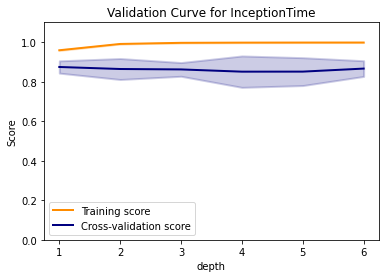

In [18]:
param_range = list(range(1, 7))

plt.title("Validation Curve for InceptionTime")
plt.xlabel(r"depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, t_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, t_mean - t_std,
                 t_mean + t_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, v_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, v_mean - v_std,
                 v_mean + v_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

## Confusion Matrix

The confusion matrix is calculated on the last fold.

In [2]:
dls = torch.load(f"dls_1024_4.pkl")

model = InceptionTime(dls.vars, dls.c, depth=1, ks=20)
f1 = F1Score(average="weighted")
learn = Learner(dls, model, metrics=[accuracy, f1])
learn.recorder.train_metrics = True

learn.fit_one_cycle(8, lr_max=0.005)

epoch,train_loss,train_accuracy,train_f1_score,valid_loss,valid_accuracy,valid_f1_score,time
0,0.290453,0.856005,0.835513,0.478456,0.863615,0.863255,00:17
1,0.216410,0.920183,0.912391,0.378388,0.902441,0.894958,00:13
2,0.190509,0.932799,0.928246,0.449500,0.889189,0.873950,00:13
3,0.171270,0.940652,0.937624,0.482843,0.884481,0.883995,00:13
4,0.150659,0.947144,0.945021,0.476737,0.888103,0.891409,00:13
5,0.135883,0.952531,0.950843,0.453483,0.895492,0.891586,00:13
6,0.129842,0.956058,0.954646,0.433699,0.903146,0.900327,00:13
7,0.128506,0.958014,0.956693,0.432540,0.902401,0.897507,00:13


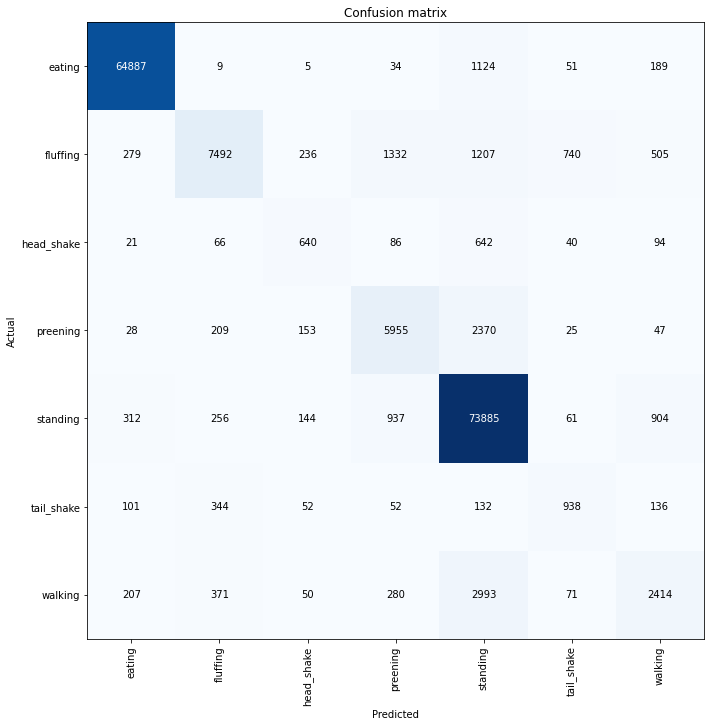

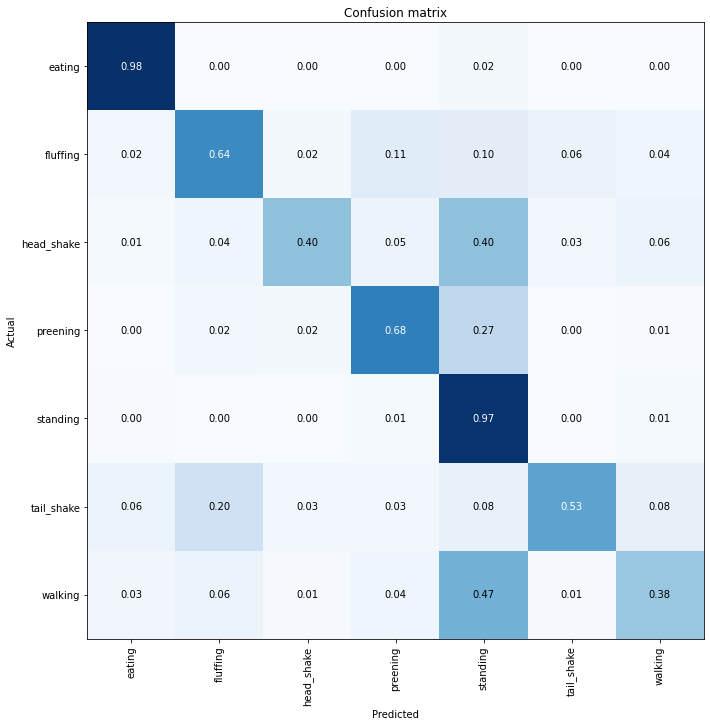

In [5]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10), cmap='Blues')
interp.plot_confusion_matrix(normalize=True, figsize=(10, 10), cmap='Blues')

## Custom Prediction Activation Function

We want to encode domain logic into the activation function used for prediction.
E.g. when head_shake is confused with standing, we want to give precedence to head_shake.


In [48]:
probas, targets, preds = learn.get_preds(dl=learn.dls.valid, with_decoded=True)

In [92]:
new_preds = []
for i, x in enumerate(probas):
    argmax = np.argmax(x)
    ind = np.argpartition(x, -2)[-2:]
    
    stand_proba = x[4]
    head_proba = x[2]
    preening_proba = x[3]
    if (all(x in ind for x in [2, 4]) and stand_proba < 0.7):
        new_preds.append(2)
    elif (all(x in ind for x in [3, 4]) and preening_proba > 0.1): 
        new_preds.append(3)
    else:
        new_preds.append(argmax)

In [93]:
from sklearn.metrics import classification_report

print(classification_report(new_preds, targets))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     65835
           1       0.64      0.86      0.73      8747
           2       0.51      0.41      0.45      1992
           3       0.77      0.57      0.66     11961
           4       0.94      0.91      0.92     78356
           5       0.53      0.49      0.51      1926
           6       0.38      0.56      0.45      4289

    accuracy                           0.90    173106
   macro avg       0.68      0.68      0.67    173106
weighted avg       0.90      0.90      0.90    173106



In [94]:
print(classification_report(preds, targets))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     65835
           1       0.64      0.86      0.73      8747
           2       0.40      0.50      0.45      1280
           3       0.68      0.69      0.68      8676
           4       0.97      0.90      0.93     82353
           5       0.53      0.49      0.51      1926
           6       0.38      0.56      0.45      4289

    accuracy                           0.90    173106
   macro avg       0.65      0.71      0.68    173106
weighted avg       0.92      0.90      0.91    173106



In [107]:
for i, x in enumerate(probas):
    max_val = torch.max(x)
    if max_val < 0.3:
        print(i)
        print(torch.argmax(x))
        print(torch.max(x))

10884
tensor(0)
tensor(0.2511)
10885
tensor(4)
tensor(0.2635)
43352
tensor(6)
tensor(0.2614)
43842
tensor(6)
tensor(0.2910)
43843
tensor(2)
tensor(0.2534)
43844
tensor(2)
tensor(0.2611)
43845
tensor(2)
tensor(0.2870)
43846
tensor(2)
tensor(0.2839)
43847
tensor(2)
tensor(0.2875)
43848
tensor(2)
tensor(0.2949)
43874
tensor(4)
tensor(0.2914)
43878
tensor(6)
tensor(0.2866)
44421
tensor(1)
tensor(0.2880)
45309
tensor(4)
tensor(0.2821)
45310
tensor(0)
tensor(0.2991)
46065
tensor(3)
tensor(0.2546)
48429
tensor(3)
tensor(0.2969)
51487
tensor(5)
tensor(0.2810)
54639
tensor(0)
tensor(0.2987)
62495
tensor(4)
tensor(0.2783)
62496
tensor(4)
tensor(0.2553)
62497
tensor(6)
tensor(0.2315)
62498
tensor(6)
tensor(0.2274)
62499
tensor(3)
tensor(0.2321)
62500
tensor(3)
tensor(0.2495)
62501
tensor(6)
tensor(0.2632)
62502
tensor(3)
tensor(0.2801)
83627
tensor(6)
tensor(0.2953)
85180
tensor(4)
tensor(0.2871)
85271
tensor(1)
tensor(0.2902)
85272
tensor(1)
tensor(0.2816)
85273
tensor(1)
tensor(0.2883)
86902
te

## Running on video

In [113]:
from winkie.dlc_importer import *

imp = DLCImporter()
df_new = imp.import_hdf('233_boxhab_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5')
df_new = transform_to_relative(df_new, 'body')
df_new = add_middle_neck(df_new)
df_new = add_rotation(df_new)
df_new = apply_rotation(df_new)

In [129]:
features = [('head', 'x'), ('head', 'y'), 
            ('tail', 'x'), ('tail', 'y'),  
            
            ('left_neck', 'x'), ('left_neck', 'y'), 
            ('right_neck', 'x'), ('right_neck', 'y'), 
            
            ('left_up_wing', 'x'), ('left_up_wing', 'y'),
            ('left_middle_wing', 'x'), ('left_middle_wing', 'y'),
            ('left_down_wing', 'x'), ('left_down_wing', 'y'),
            
            ('right_up_wing', 'x'), ('right_up_wing', 'y'),
            ('right_middle_wing', 'x'), ('right_middle_wing', 'y'),
            ('right_down_wing', 'x'), ('right_down_wing', 'y'),
]

x, _ = SlidingWindow(16, get_x=features)(df_new)

In [152]:
test_ds = learn.dls.dataset.add_test(x)
test_dl = learn.dls.valid.new(test_ds)

In [153]:
probas, targets, preds = learn.get_preds(dl=test_dl, with_decoded=True)

In [158]:
len(preds)

71909

In [159]:
import cv2
import numpy as np

np.set_printoptions(precision=2)

cap = cv2.VideoCapture('233_boxhab_gopro_cut_day1.MP4')
framerate = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('233_boxhab_gopro_cut_day1_pred_it.mp4', fourcc, framerate, (1280,  960))
frame_number = 0
while True:
    ret, frame = cap.read()
    if ret:

        b = str(preds[frame_number].item())
        proba = str(probas[frame_number])
        cv2.putText(frame, b, (70, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (130, 255, 130), 2, cv2.LINE_AA)
        cv2.putText(frame, proba, (70, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (130, 255, 130), 1, cv2.LINE_AA)
        
        
        for i, v in enumerate(probas[frame_number]):
#             label = clf.classes_[i]
            y_pos = 120 + 20 * i
            x_pos = 250
            
#             cv2.putText(frame, label, (70, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 1, (130, 255, 130), 1, cv2.LINE_AA)
            
            bar = (int(x_pos + 100 * probas[frame_number][i].item()), y_pos)
            cv2.line(frame, (x_pos, y_pos), bar, (0,0,255), 10)
        
        out.write(frame)

        frame_number = frame_number + 1
        if frame_number == 71908:
            break
    else:
        break

cap.release()
out.release()

In [160]:
learn.save_all(path='inception_time', dls_fname='dls', model_fname='model', learner_fname='learner')